In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

In [2]:
df = pd.read_csv('Jungle.csv')
lane = df.drop(columns = ['Lane', 'Unnamed: 0', 'Summoner', 'Item_0', 'Item_1', 'Item_2', 'Item_3', 'Item_4', 'Item_5', 'Item_6'])

In [3]:
lane.head()

,Champion,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls,champion_name
0,517,6,3,15,3,1,29163,9691,7512,22739,12524,16,3,27,27,Sylas
1,163,4,4,11,2,1,9796,11092,2255,14925,9226,13,1,30,8,Taliyah
2,517,4,9,5,2,1,6648,3168,130,21623,10634,14,1,15,10,Sylas
3,104,7,4,5,4,1,22269,11399,6658,27669,13684,17,1,16,15,Graves
4,517,4,7,6,2,1,18760,12753,1169,25861,10392,15,2,32,25,Sylas


# Lots of champions can be played in any lane due to one trick players getting auto-filled. So to make sure my clustering is built on sufficient data, I am filtering out champions who are played less than 5 times in this role.

In [4]:
for champ in list(lane.groupby('Champion').count().query("Kills < 5").index):
    lane = lane[lane['Champion'] != champ]                           

In [5]:
lane = lane.groupby("Champion").mean()

In [6]:
lane.head()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Champion,,,,,,,,,,,,,,
5,5.397260,5.501370,7.116438,2.608219,1.309589,12900.460274,18758.515068,2111.441096,26172.350685,10031.519178,13.013699,3.609589,26.709589,16.631507
9,3.939058,6.260388,9.761773,1.722992,1.174515,12934.936288,5537.667590,1149.188366,17910.587258,8792.445983,12.318560,5.445983,40.858726,72.204986
11,7.904930,5.838028,4.721831,3.556338,1.887324,15324.785211,20460.235915,2597.000000,23866.028169,11062.992958,13.102113,1.066901,17.334507,3.929577
19,5.218182,5.395455,6.600000,2.577273,1.300000,9820.863636,15354.263636,1001.527273,28848.504545,10016.631818,13.186364,2.709091,21.550000,20.045455
20,3.490987,4.260944,10.577682,1.919313,1.094421,9220.329614,19190.307296,746.838627,30120.744206,9285.981116,12.764807,3.512446,23.423176,27.707296


# To determine the optimal amount of clusters, I am going to run a loop of various K values and plot the errors to pick the ideal number of clusters based on where the "elbow" is.

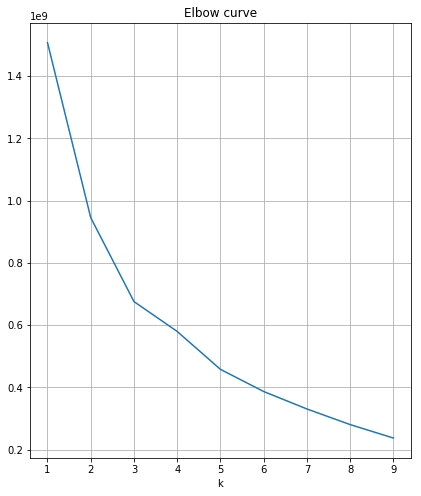

In [10]:
distorsions = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(lane)
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.plot(range(1, 10), distorsions)
plt.grid(True)

There is no clear "elbow" here to easily determine the ideal number of clustes. As such, I am going to use the silhouette plot to determine the ideal number of clusters based on this data.

In [14]:
silhouette_plot = []
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(lane)
    silhouette_avg = metrics.silhouette_score(lane, cluster_labels)
    silhouette_plot.append(silhouette_avg)

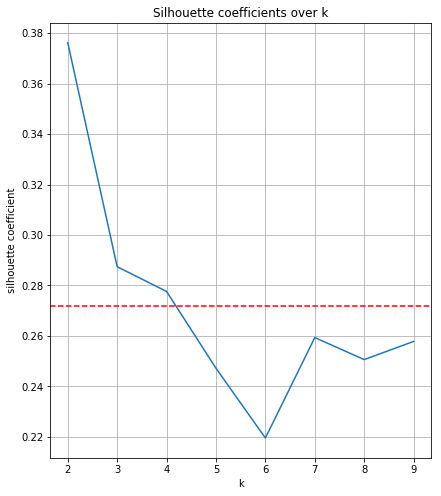

In [16]:
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

The highest point, which also happens to be the second "elbow" is at 6 clusters and so I will use that to further analyze the playstyles in the bot lane.

In [17]:
k_means = KMeans(n_clusters = 3).fit(lane.groupby('Champion').mean())
cluster_assignments = k_means.predict(lane.groupby('Champion').mean())

In [18]:
cluster_assignments

array([0, 2, 1, 0, 0, 1, 1, 0, 2, 1, 0, 2, 0, 1, 0, 0, 1, 0, 2, 0, 1, 0,
       0, 1, 0, 0, 2, 1, 1, 0, 2, 2], dtype=int32)

In [19]:
clustered = lane.groupby('Champion').mean()

In [20]:
clustered['Cluster'] = cluster_assignments

In [21]:
clustered.groupby("Cluster").count()['Kills']

Cluster
0    15
1    10
2     7
Name: Kills, dtype: int64

There are 5 champions in Cluster 0, 4 champions in cluster 1, 6 champions in cluster 2, and ONLY 1 champion in cluster 3. 

In [22]:
clustered.groupby("Cluster").mean()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Cluster,,,,,,,,,,,,,,
0,4.851200,4.962833,8.069997,2.442777,1.259991,11412.853740,16368.376372,1378.044067,27090.658555,9980.561142,13.161045,3.503047,24.565098,20.475979
1,6.516485,5.164375,6.584379,3.192168,1.462251,15032.328551,18414.328049,1697.024544,21878.826728,10595.550690,13.351375,2.642689,23.594708,12.437224
2,4.633598,5.141120,8.584814,2.270691,1.217463,12889.736023,8516.774568,1532.253287,19796.166324,9536.047467,13.039758,3.366667,25.600236,46.164995


# Based on the average values of the clusters above, it looks like the one champion in Cluster 2 had an outlier performance where the values are drastically different from every other cluster.

In [23]:
champion_names = 'http://ddragon.leagueoflegends.com/cdn/9.13.1/data/en_US/champion.json?fbclid=IwAR3wpqEjCmWqLKToVoMwWz-iGVCkHaVVfVOWtvy9OpfKrM7Hjt1YZ4VyPk8'

df = pd.read_json(champion_names)

champs = []
ids = []
for names in list(df['data']):
    champs.append(names['id'])
    ids.append(names['key'])

champ_dict = {}

for champ in range(len(champs)):
    champ_dict[ids[champ]] = champs[champ]

clustered['champion_name'] = clustered.index.map(lambda x: champ_dict[str(x)] )



In [27]:
clustered[clustered['Cluster'] == 2]

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls,Cluster,champion_name
Champion,,,,,,,,,,,,,,,,
9,3.939058,6.260388,9.761773,1.722992,1.174515,12934.936288,5537.667590,1149.188366,17910.587258,8792.445983,12.318560,5.445983,40.858726,72.204986,2,Fiddlesticks
33,3.623932,5.162393,9.051282,1.735043,1.051282,9544.478632,8749.837607,1077.884615,23444.978632,8922.529915,12.585470,2.478632,19.790598,31.666667,2,Rammus
56,5.687075,5.442177,5.761905,2.598639,1.401361,12935.183673,12388.564626,2376.136054,22560.850340,10301.326531,13.462585,2.027211,20.340136,124.387755,2,Nocturne
79,4.354229,4.670647,8.415920,2.288557,1.176119,12913.159204,11001.318408,1064.200995,22099.251741,9291.670647,12.841791,4.302488,29.603980,24.918408,2,Gragas
163,6.925684,5.492829,8.173403,3.555411,1.462842,18781.428944,9417.239896,1676.873533,18851.792699,10744.084746,13.610169,3.938722,26.812256,15.074316,2,Taliyah
427,2.196721,3.581967,12.434426,1.163934,0.893443,7152.483607,6661.655738,1373.663934,12339.204918,8513.770492,12.852459,2.713115,22.237705,35.278689,2,Ivern
517,5.708487,5.377438,6.494992,2.830258,1.362678,15966.481813,5861.138113,2007.825514,21366.498682,10186.503954,13.607275,2.660517,19.558250,19.624143,2,Sylas


# 

In [28]:
clustered.groupby('Cluster').mean()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Cluster,,,,,,,,,,,,,,
0,4.851200,4.962833,8.069997,2.442777,1.259991,11412.853740,16368.376372,1378.044067,27090.658555,9980.561142,13.161045,3.503047,24.565098,20.475979
1,6.516485,5.164375,6.584379,3.192168,1.462251,15032.328551,18414.328049,1697.024544,21878.826728,10595.550690,13.351375,2.642689,23.594708,12.437224
2,4.633598,5.141120,8.584814,2.270691,1.217463,12889.736023,8516.774568,1532.253287,19796.166324,9536.047467,13.039758,3.366667,25.600236,46.164995
